<b><font size=5><a href="https://www.kaggle.com/c/LANL-Earthquake-Prediction">LANL Earthquake Prediction</a> <u>(A Kaggle Competition)</u></font></b>

<p><font size="4">About</font></p>

Accoustic data (Sound wave) and its variation with time to impact has been provided. I found certain inconsistency as the data provided has more than one set of experiment (17 to be precise). For each set of experiment the accoustic data and time_to_failure is given and the time will keep on decreasing till the impact. For training only one csv file was provided which requires certain pre processing to split them into experiment (or segment as per the LANL). 

<p><font size="4">Training Data Preparation</font></p>

Test data are given as a csv files. Each file belongs to a particular segment of an experiment and we need to find the time_to_failure, which is nothing but the time remaining till the earthquake hits. This is not aligned with what training data is. Currently a single csv file having multiple experiments (Without Demarcation) is provided. First we need to split the file into individual experiment chunks.

There are more than one ways to split the training data. I have used the following two :
    1. Read the entire csv file in chunks and save them into individual csvs. This will end up in 4000+ files.
    2. Read the entire csv file in chunks and comapre the rows till the time_to_failure starts increasing instead of decreasing. The increase of time suggests the impact has happened and the next row belongs to new experiment or segment. This will generate 17 files.

My code to split data in the format prescribed in 2nd is slow and could have been <b>much</b> better but I am not going to change as it is just a tool to separate data and not the goal. 
Do not execute the following script as it will take 3 days to complete. Files are already generated and kept in data_train folder. We will call this experiment data as <b>DATA-II</b> and will be using this for actual training.

<b>%load<b> <font color="green">data_splitter.py</font>

The format prescribed in 1st is fast and will simply split the entire train file into chunks of 150000 rows. This does not consider if the entire segment belong to one experiment or multiple. This will not be used in actual training, however this will come very handy in evaluating model during my initial analysis. We will call this data as <b>DATA-I</b>.

<p> <font size="4">Exploratory Data Analysis <b>(EDA)</b></font> </p>

<p>Preparation For Training Data</p>

With DATA-II, we cannot use this data directly for our training purpose as the formats are still not aligned with our test data. Individual files in DATA-II is large and requires to be in test format which only has segments of 150000 rows. We have used train_data_generator.py to split these experiments data into small files. 

The script loads individual file of DATA-II and randomly picks 150000 rows to generate a chunk. The idea is to do a sampling of the experimental data rather than using exact same copy. This will align our training set with test set. Again do not execute the script as the data is already genertaed and kept under train_data_new folder. We will call this data set as <b>DATA-III</b>

<b>%load<b> <font color="green">train_data_generator.py</font>

<p>What is going on</p>

So far we have already executed multiple pre processing on the training data, so is it now ready? Well , no actually. The problem is we cannot go on and execute each step every time during our analysis process so we need to somewhow pre process and save the data into file and use that file for all modeling puprposes. So Let's create a class which will read DATA-III and test data and outputs a file that have sampling attributes. Let's dive into the following class code to for better understaning.

Since I prefer eclipse for writing code, all classes or scripts found within the notebook is also be found in the file structure.
<b>%load<b> <font color="green">accoustic_sampler.py</font>

In [2]:
import pandas as pd
import os
from pathlib import Path


class AccousticSampler:
    
    def __init__(self, path_data, data_type='train'):
        self.path_data = path_data;
        self.data_type = data_type;
        self.train_data_record_list = []
        self.train_modeled_data_filename = 'train_modeled_data_old.csv'
        self.test_modeled_data_filename = 'test_modeled_data_old.csv'
        self.train_data_columns = ['segment_id', 'acc_mean', 'acc_sd', 'acc_min', 'acc_max', 'chg_acc_min', 'chg_acc_max', 'time_to_failure']
        self.test_data_columns = ['segment_id', 'acc_mean', 'acc_sd', 'acc_min', 'acc_max', 'chg_acc_min', 'chg_acc_max']
    
    def __readFiles(self):
        import glob;
        files = glob.glob(self.path_data + '/*.csv')   
        print('Loading files for path', self.path_data)
        for file in files: 
            print('Loading file', file)    
            self.__load_data(file)
        self.__saveData()
        print('Loading files within path', self.path_data, 'completed successfully')
    
    def __load_data(self, filename):
        seg_name = os.path.basename(filename)
        seg_name = seg_name[0:-4]
        df = pd.read_csv(filename)
        df['acoustic_data'] = pd.to_numeric(df['acoustic_data'], errors='coerce')
        df['time_to_failure'] = pd.to_numeric(df['time_to_failure'], errors='coerce')
        df['change_in_data'] = df['acoustic_data'].diff()
        df = df.dropna(axis=0);
        # df['time_to_failure'] = df['time_to_failure'].apply(lambda x: x * 1000000)
        if self.data_type == 'train':
            self.__record_keeper_train(df, seg_name)
        else:
            self.__record_keeper_test(df, seg_name)
    
    def __record_keeper_train(self, sample_df, seg_name):
        sample_stats = sample_df.describe()
        record = {'segment_id':seg_name, 'acc_mean' : sample_stats['acoustic_data']['mean'], 'acc_sd' : sample_stats['acoustic_data']['std'], 'acc_min' : sample_stats['acoustic_data']['min'], \
                  'acc_max' : sample_stats['acoustic_data']['max'], 'chg_acc_min' : sample_stats['change_in_data']['min'], 'chg_acc_max' : sample_stats['change_in_data']['max'], \
                   'time_to_failure' : sample_stats['time_to_failure']['min']\
                   , 'median_25': sample_stats['acoustic_data']['25%'], 'median_50': sample_stats['acoustic_data']['50%'], 'median_70': sample_stats['acoustic_data']['75%']}
        self.train_data_record_list.append(record) 
        if len(self.train_data_record_list) > 5000:
            self.__saveData()
    
    def __record_keeper_test(self, sample_df, seg_name):
        sample_stats = sample_df.describe()
        record = {'segment_id':seg_name, 'acc_mean' : sample_stats['acoustic_data']['mean'], 'acc_sd' : sample_stats['acoustic_data']['std'], 'acc_min' : sample_stats['acoustic_data']['min'], \
                  'acc_max' : sample_stats['acoustic_data']['max'], 'chg_acc_min' : sample_stats['change_in_data']['min'], 'chg_acc_max' : sample_stats['change_in_data']['max']}
        self.train_data_record_list.append(record) 
        if len(self.train_data_record_list) > 5000:
            self.__saveData()
    
    def __saveData(self):
        record_df = pd.DataFrame(self.train_data_record_list)
        if self.data_type == 'train':
            record_df.to_csv(self.train_modeled_data_filename, mode='a', index=False)
        else:
            record_df.to_csv(self.test_modeled_data_filename, mode='a', index=False)
        self.train_data_record_list.clear()
        print('Flushed intermediate records into file')
        
    def fit(self):
        seg_file = None
        if self.data_type == 'train':
            seg_file = Path(self.train_modeled_data_filename)
        else:
            seg_file = Path(self.test_modeled_data_filename)
        if seg_file.is_file():
                print('Data file already exists ..Fitting completed')
        else:
            self.__readFiles();
            print('Data fitting completed')
    
    def get(self):
        seg_file = None
        if self.data_type == 'train':
            seg_file = Path(self.train_modeled_data_filename)
            if seg_file.is_file():
                return pd.read_csv(self.train_modeled_data_filename)
            else:
                raise ValueError('Execute fit before get .. ') 
        else:
            seg_file = Path(self.test_modeled_data_filename)
            if seg_file.is_file():
                return pd.read_csv(self.test_modeled_data_filename)
            else:
                raise ValueError('Execute fit before get .. ') 


The above class will read all the csv files for a given folder, find there statisticla values like mean , median , standard deviation etc. save each file as one record. Keep a note on the file name as the same name will be used as segment id within the training and test file.

Let's try this class on DATA-I reason being it is small and will help us to understand correlations and other aspects.

In [1]:
import accoustic_sampler as acs
import pandas as pd

sampler = acs.AccousticSampler('D:/PYTHON_WORKSPACES/Kaggles/EarthquakePrediction/LANL_Earthquake/data/train_data_new')
sampler.fit()
data_df = sampler.get()

import data_formatter as dtFrm
# This formatter is available within the path and has all formatting techniques used earlier in the notebook. The doTransform parameter 
# controls weather or not we need to do any logarthmic transformation or not.

formatter = dtFrm.LANLDataFormatter(data_df=data_df, data_type='train', doTransform=True, doScale=True)
data_df = formatter.transform()

Data file already exists ..Fitting completed


From the above correlation following attributes looks strong contender :
median_70,median_25, chg_acc_min/max , acc_sd and acc_max.
We can try some logarthmic transformation and see if this improves correlation or not. 

In [3]:
df_trf = pd.DataFrame(data_df);
df_trf.corr()['time_to_failure']

acc_max                  -0.362961
acc_min                   0.382586
acc_sd                   -0.498941
chg_acc_max              -0.358661
chg_acc_min               0.363229
median_25                 0.350963
median_70                -0.383129
time_to_failure           1.000000
time_per_max_range        0.366629
distance                 -0.376633
time_per_max_chg_range    0.371938
Name: time_to_failure, dtype: float64

After the transformations correlations are much better and also suggests a logarthmic relation between the attributes and 'time_to_failure'. Let's first try logistic regression on the given data set and see how it performs

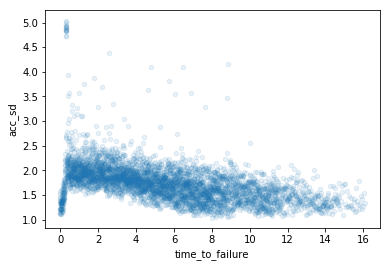

In [25]:
df_trf.plot(kind="scatter", x="time_to_failure", y="acc_sd", alpha=0.1)

In [3]:
#Splitting data into test and train
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df_trf, test_size=0.1, random_state=42)
# Separate output from inputs
y_train = train_set['time_to_failure']
x_train_seg = train_set['segment_id']
x_train = train_set.drop(['time_to_failure'], axis=1)
x_train = x_train.drop(['segment_id'], axis=1)


y_test = test_set['time_to_failure']
x_test_seg = test_set['segment_id']
x_test = test_set.drop(['time_to_failure'], axis=1)
x_test = x_test.drop(['segment_id'], axis=1)

x_train.head(5)

,acc_max,acc_min,acc_sd,chg_acc_max,chg_acc_min,median_25,median_70
73731,0.203594,0.731466,0.074961,0.152748,0.875071,0.833333,0.000000
69150,0.325084,0.645540,0.122468,0.234890,0.775959,0.833333,0.166667
124492,0.114456,0.856364,0.033070,0.043394,0.972661,0.833333,0.000000
12942,0.247521,0.719396,0.122816,0.144861,0.827910,0.833333,0.000000
52037,0.421990,0.580020,0.286318,0.351844,0.675659,0.833333,0.166667


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.0001, 0.1), "C": uniform(1, 50), "kernel":['rbf','poly','linear','sigmoid'] 
                       ,"max_iter":[500000],"degree":uniform(3, 10),"tol":[0.001,0.01,0.0001],"epsilon":[0.1,0.01,0.001]}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=200, verbose=2,n_jobs=4, random_state=7)
rnd_search_cv.fit(x_train, y_train)
rnd_search_cv.best_estimator_

D:\Anaconda\envs\ptc\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 200 candidates, totalling 600 fits


In [35]:
svReg = SVR(C=8.31993941811405, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.015751320499779724, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)
svReg.fit(x_train,y_train)

SVR(C=8.31993941811405, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.015751320499779724, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [38]:
# Check score for the test cases
svReg.score(x_test,y_test)

0.3620526238839221

Score is not very high but then this is a sample case with very few data points. Now we will use DATA-III for our actual training purpose.

<b>NOTE: </b><i>We will be using the class within the path and not within the notebook. Only difference is the name of the file that the class treats as train data. For the class within this notebook the filename is train_modeled_data_old.csv and for the class within path it is train_modeled_data.csv. Same goes for the test data file.</i>

In [64]:
import accoustic_sampler as acs
# Create object with the directory path having training files
sampler = acs.AccousticSampler('D:/PYTHON_WORKSPACES/Kaggles/EarthquakePrediction/LANL_Earthquake/data/train_data_new')
sampler.fit()
train_df = sampler.get()
train_df.head(5)

Data file already exists ..Fitting completed


,acc_max,acc_mean,acc_min,acc_sd,chg_acc_max,chg_acc_min,median_25,median_50,median_70,segment_id,time_to_failure
0,177.0,4.388199606653555,-142.0,13.704960870433874,54.0,-58.0,0.0,4.0,9.0,seg_000,0.27319883152
1,120.0,4.68458948631621,-89.0,5.752406145638193,43.0,-45.0,2.0,5.0,7.0,seg_001,1.1796968053
2,121.0,4.404168083361667,-121.0,7.697446640219251,48.0,-48.0,1.0,4.0,7.0,seg_0010,0.25729589012
3,139.0,4.37621920730691,-153.0,7.511764610066801,39.0,-38.0,2.0,4.0,7.0,seg_00100,0.99249705282
4,142.0,4.971872395746525,-144.0,6.355934086624004,77.0,-50.0,3.0,5.0,7.0,seg_00101,1.2499962564


In [65]:
#Adjust all null or empty fields
train_df['acc_max'] = pd.to_numeric(train_df['acc_max'], errors='coerce')
train_df['acc_mean'] = pd.to_numeric(train_df['acc_mean'], errors='coerce')
train_df['acc_min'] = pd.to_numeric(train_df['acc_min'], errors='coerce')
train_df['acc_sd'] = pd.to_numeric(train_df['acc_sd'], errors='coerce')
train_df['chg_acc_max'] = pd.to_numeric(train_df['chg_acc_max'], errors='coerce')
train_df['chg_acc_min'] = pd.to_numeric(train_df['chg_acc_min'], errors='coerce')
train_df['median_25'] = pd.to_numeric(train_df['median_25'], errors='coerce')
train_df['median_50'] = pd.to_numeric(train_df['median_50'], errors='coerce')
train_df['median_70'] = pd.to_numeric(train_df['median_70'], errors='coerce')
train_df['time_to_failure'] = pd.to_numeric(train_df['time_to_failure'], errors='coerce') 

train_df.head(5)

,acc_max,acc_mean,acc_min,acc_sd,chg_acc_max,chg_acc_min,median_25,median_50,median_70,segment_id,time_to_failure
0,177.0,4.388200,-142.0,13.704961,54.0,-58.0,0.0,4.0,9.0,seg_000,0.273199
1,120.0,4.684589,-89.0,5.752406,43.0,-45.0,2.0,5.0,7.0,seg_001,1.179697
2,121.0,4.404168,-121.0,7.697447,48.0,-48.0,1.0,4.0,7.0,seg_0010,0.257296
3,139.0,4.376219,-153.0,7.511765,39.0,-38.0,2.0,4.0,7.0,seg_00100,0.992497
4,142.0,4.971872,-144.0,6.355934,77.0,-50.0,3.0,5.0,7.0,seg_00101,1.249996


In [66]:
train_df.corr()

,acc_max,acc_mean,acc_min,acc_sd,chg_acc_max,chg_acc_min,median_25,median_50,median_70,time_to_failure
acc_max,1.000000,0.010459,-0.957949,0.966339,0.975047,-0.963828,-0.374825,-0.016228,0.389353,-0.187054
acc_mean,0.010459,1.000000,-0.003771,0.007734,0.006219,-0.013236,0.517504,0.793778,0.514364,-0.027074
acc_min,-0.957949,-0.003771,1.000000,-0.965153,-0.958507,0.941507,0.372881,0.024360,-0.382099,0.192182
acc_sd,0.966339,0.007734,-0.965153,1.000000,0.960570,-0.941114,-0.407656,-0.019972,0.421228,-0.216132
chg_acc_max,0.975047,0.006219,-0.958507,0.960570,1.000000,-0.952955,-0.377067,-0.019818,0.388945,-0.194269
chg_acc_min,-0.963828,-0.013236,0.941507,-0.941114,-0.952955,1.000000,0.357506,0.014549,-0.376322,0.189902
median_25,-0.374825,0.517504,0.372881,-0.407656,-0.377067,0.357506,1.000000,0.437623,-0.094731,0.351010
median_50,-0.016228,0.793778,0.024360,-0.019972,-0.019818,0.014549,0.437623,1.000000,0.398355,-0.005877
median_70,0.389353,0.514364,-0.382099,0.421228,0.388945,-0.376322,-0.094731,0.398355,1.000000,-0.381781
time_to_failure,-0.187054,-0.027074,0.192182,-0.216132,-0.194269,0.189902,0.351010,-0.005877,-0.381781,1.000000


In [67]:
#Check for NAN columns
import utility as util
columns_numeric = ['acc_max','acc_mean','acc_min','acc_sd','chg_acc_max','chg_acc_min','median_25','median_50','median_70']
util.checkNaNColumns(columns_numeric,train_df)

acc_max 1
acc_mean 1
acc_min 1
acc_sd 1
chg_acc_max 1
chg_acc_min 1
median_25 1
median_50 1
median_70 1


In [68]:
# Remove all NAN columns
train_df = train_df.dropna()
util.checkNaNColumns(columns_numeric,train_df)

acc_max 0
acc_mean 0
acc_min 0
acc_sd 0
chg_acc_max 0
chg_acc_min 0
median_25 0
median_50 0
median_70 0


In [69]:
# Using log transformation as did previously
train_df['acc_sd'] = train_df['acc_sd'].apply(lambda x:np.log(x))
train_df['chg_acc_max'] = train_df['chg_acc_max'].apply(lambda x:np.log(x))
train_df['chg_acc_min'] = train_df['chg_acc_min'].apply(lambda x: np.log(x) if x>0  else -1*np.log(-1*x))
train_df['acc_min'] = train_df['acc_min'].apply(lambda x: np.log(x) if x>0  else -1*np.log(-1*x))
train_df['acc_max'] = train_df['acc_max'].apply(lambda x: np.log(x) if x>0  else -1*np.log(-1*x))
train_df.corr()

,acc_max,acc_mean,acc_min,acc_sd,chg_acc_max,chg_acc_min,median_25,median_50,median_70,time_to_failure
acc_max,1.000000,-0.004031,-0.951767,0.885793,0.946427,-0.942081,-0.420476,-0.033080,0.411226,-0.364006
acc_mean,-0.004031,1.000000,0.013047,-0.007453,-0.007342,0.003002,0.517504,0.793778,0.514364,-0.027074
acc_min,-0.951767,0.013047,1.000000,-0.888018,-0.942059,0.939312,0.429060,0.044998,-0.412485,0.384561
acc_sd,0.885793,-0.007453,-0.888018,1.000000,0.871678,-0.871991,-0.556041,-0.044575,0.541773,-0.498726
chg_acc_max,0.946427,-0.007342,-0.942059,0.871678,1.000000,-0.929071,-0.413311,-0.035188,0.402426,-0.358404
chg_acc_min,-0.942081,0.003002,0.939312,-0.871991,-0.929071,1.000000,0.411640,0.032257,-0.403573,0.363730
median_25,-0.420476,0.517504,0.429060,-0.556041,-0.413311,0.411640,1.000000,0.437623,-0.094731,0.351010
median_50,-0.033080,0.793778,0.044998,-0.044575,-0.035188,0.032257,0.437623,1.000000,0.398355,-0.005877
median_70,0.411226,0.514364,-0.412485,0.541773,0.402426,-0.403573,-0.094731,0.398355,1.000000,-0.381781
time_to_failure,-0.364006,-0.027074,0.384561,-0.498726,-0.358404,0.363730,0.351010,-0.005877,-0.381781,1.000000


In [70]:
#Removing Attributes which are not corelated
train_df = train_df.drop(['acc_mean','median_50'],axis=1)

In [1]:
import accoustic_sampler as acs
import data_formatter as dtFrm
import numpy as np

sampler = acs.AccousticSampler('D:/PYTHON_WORKSPACES/Kaggles/EarthquakePrediction/LANL_Earthquake/data/train_data_new')
sampler.fit()
data_df = sampler.get()
# columns_to_drop=columns_to_drop
formatter = dtFrm.LANLDataFormatter(data_df=data_df, data_type='train', doTransform=True, doScale=True, cols_to_keep=50)
data_df = formatter.transform()

# Separate output from inputs
y_train = data_df['time_to_failure']
x_train_seg = data_df['segment_id']
x_train = data_df.drop(['time_to_failure'], axis=1)
x_train = data_df.drop(['segment_id'], axis=1)

Data file already exists ..Fitting completed
Transformation completed ... 
Dropping columns  ['acc_mean', 'median_50', 'auc'] ...
Min Max Scaler applied ... 


In [2]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

from sklearn.metrics import mean_absolute_error, make_scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

param_distributions = {"gamma": reciprocal(0.0001, 0.1), "C": uniform(1, 50), "kernel":['rbf','poly','linear','sigmoid'] 
                       ,"max_iter":[-1],"degree":[2,3],"tol":[0.001,0.01,0.0001],"epsilon":[0.1,0.01,0.001]}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=1000, verbose=2,n_jobs=3,cv=3, random_state=42,\
                                   scoring=mae_scorer)
rnd_search_cv.fit(x_train, y_train)
rnd_search_cv.best_estimator_

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   12.0s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:   59.8s
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 36.4min
[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed: 72.3min
[Parallel(n_jobs=3)]: Done 1007 tasks      | elapsed: 109.1min
[Parallel(n_jobs=3)]: Done 1452 tasks      | elapsed: 163.1min
[Parallel(n_jobs=3)]: Done 1979 tasks      | elapsed: 170.5min
[Parallel(n_jobs=3)]: Done 2586 tasks      | elapsed: 214.2min
[Parallel(n_jobs=3)]: Done 3000 out of 3000 | elapsed: 284.7min finished


SVR(C=37.08647605824366, cache_size=200, coef0=0.0, degree=2, epsilon=0.001,
  gamma=0.000586414861763494, kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
rnd_search_cv.cv_results_ 

In [17]:
from sklearn.svm import SVR
svReg = SVR(C=50.394989415641891, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.06161049539380964, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

svReg.fit(x_train, y_train)

SVR(C=50.39498941564189, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.06161049539380964, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [9]:
svReg.score(x_test,y_test)

0.374987652896806

In [18]:
y_pred = svReg.predict(x_test)

In [19]:
from sklearn.metrics.regression import mean_absolute_error
mean_absolute_error(y_test,y_pred)

2.1188032440094706

Well the score is too bad to proceed. Few things we need to look after. Accuracy is around 40% and it seems more than one model might be needed to get better score. Let's try with Random Forest Regressor.

Let's try Random Forest Regressor

In [1]:
import accoustic_sampler as acs

degree = 2
columns_to_keep = 35

sampler = acs.AccousticSampler('D:/PYTHON_WORKSPACES/Kaggles/EarthquakePrediction/LANL_Earthquake/data/train_data_new')
sampler.fit()
data_df = sampler.get()

import data_formatter as dtFrm
# This formatter is available within the path and has all formatting techniques used earlier in the notebook. The doTransform parameter 
# controls weather or not we need to do any logarthmic transformation or not.

formatter = dtFrm.LANLDataFormatter(data_df=data_df, data_type='train', doTransform=True,doScale=True)
data_df = formatter.transform()

corr = data_df.corr()['time_to_failure']
most_dependent_columns = corr.abs().nlargest(columns_to_keep + 1, keep='all').index[0:]
most_dependent_columns = most_dependent_columns.tolist()
most_dependent_columns.append('segment_id')
data_df = data_df[most_dependent_columns]

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data_df, test_size=0.5, random_state=42)
# Separate output from inputs
y_train = train_set['time_to_failure']
x_train_seg = train_set['segment_id']
x_train = train_set.drop(['time_to_failure'], axis=1)
x_train = x_train.drop(['segment_id'], axis=1)

y_test = test_set['time_to_failure']
x_test_seg = test_set['segment_id']
x_test = test_set.drop(['time_to_failure'], axis=1)
x_test = x_test.drop(['segment_id'], axis=1)

Data file already exists ..Fitting completed
Transformation completed ... 
Standard Scaler applied ... 
Dropping columns  ['acc_mean', 'median_50', 'auc'] ...


In [2]:
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
import numpy as np

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_depth': [10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200,
  None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [3]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)
rf_random.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 239.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 525.4min finished


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=60,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1800, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [1]:
import accoustic_sampler as acs
import data_formatter as dtFrm
sampler = acs.AccousticSampler('D:/PYTHON_WORKSPACES/Kaggles/EarthquakePrediction/LANL_Earthquake/data/train_data_new')
sampler.fit()
data_df = sampler.get()

formatter = dtFrm.LANLDataFormatter(data_df=data_df, data_type='train', doTransform=True)
data_df = formatter.transform()

#data_df = data_df.drop(['acc_max','acc_min','chg_acc_max','chg_acc_min'],axis=1)
# Splitting data into test_1 and train
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data_df, test_size=0.2, random_state=42)
# Separate output from inputs
y_train = train_set['time_to_failure']
x_train_seg = train_set['segment_id']
x_train = train_set.drop(['time_to_failure'], axis=1)
x_train = x_train.drop(['segment_id'], axis=1)

y_test = test_set['time_to_failure']
x_test_seg = test_set['segment_id']
x_test = test_set.drop(['time_to_failure'], axis=1)
x_test = x_test.drop(['segment_id'], axis=1)

Data file already exists ..Fitting completed
Transformation completed ... 
Dropping columns  ['acc_mean', 'median_50', 'auc'] ...


In [2]:
from sklearn.ensemble.forest import RandomForestRegressor
randForReg = RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=170,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=4,
           oob_score=False, random_state=None, verbose=2, warm_start=False)
randForReg.fit(x_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 800
building tree 2 of 800
building tree 3 of 800
building tree 4 of 800
building tree 5 of 800
building tree 6 of 800
building tree 7 of 800
building tree 8 of 800
building tree 9 of 800
building tree 10 of 800
building tree 11 of 800
building tree 12 of 800
building tree 13 of 800
building tree 14 of 800
building tree 15 of 800
building tree 16 of 800
building tree 17 of 800
building tree 18 of 800


KeyboardInterrupt: 

In [15]:
randForReg.score(x_test,y_test)

0.9816723538691756

In [ ]:
from sklearn.metrics.regression import mean_absolute_error
y_pred = randForReg.predict(x_test)
mean_absolute_error(y_test,y_pred)

VOILA! This seems pretty good. Our svm score is not great however RandomForest witth 800 estimetors has did the trick. Let's proceed for actula test file. But before that we must train the model with entire data set now.

In [7]:
import accoustic_sampler as acs
import data_formatter as dtFrm
sampler = acs.AccousticSampler('D:/PYTHON_WORKSPACES/Kaggles/EarthquakePrediction/LANL_Earthquake/data/train_data_new')
sampler.fit()
data_df = sampler.get()

formatter = dtFrm.LANLDataFormatter(data_df=data_df, data_type='train', doTransform=True)
train_df = formatter.transform()
print('Train data size ',train_df.shape[0])
train_df.head(10)

Data file already exists ..Fitting completed
Train data size  125821


,acc_max,acc_min,acc_sd,chg_acc_max,chg_acc_min,median_25,median_70,segment_id,time_to_failure,time_per_max_range,distance,time_per_max_chg_range
0,4.875197,-4.762174,1.951047,3.688879,-3.555348,2.0,7.0,5J8Aoorc,0.718996,0.000686,5.557186,0.002269
1,4.744932,-4.624973,1.883296,3.828641,-3.737670,2.0,7.0,4KBrRoSo,0.479596,0.000781,5.456024,0.001926
2,4.025352,-3.912023,1.153917,3.044522,-3.091042,2.0,6.0,jb3Q37EU,0.030598,0.001540,4.739611,0.003796
3,4.709530,-4.744932,1.745552,3.688879,-3.828641,2.0,7.0,ewfS5gDo,1.382997,0.000800,5.488152,0.002102
4,4.976734,-5.087596,1.944435,3.828641,-4.060443,2.0,7.0,dy32aN4v,0.812699,0.000545,5.781167,0.001609
5,5.267858,-5.147494,1.969736,4.094345,-4.127134,2.0,7.0,UjpSjrHG,0.381696,0.000465,5.955314,0.001394
6,4.615121,-4.521789,1.944932,3.663562,-3.610918,2.0,7.0,ER3XKUcI,0.760496,0.000875,5.334768,0.002223
7,4.094345,-4.007333,1.268534,3.091042,-3.258097,2.0,6.0,PTnwd7Tk,0.189196,0.001417,4.825232,0.003396
8,5.023881,-4.836282,1.900622,3.931826,-3.828641,2.0,7.0,8xz5KcPU,1.090396,0.000647,5.685064,0.001853
9,4.787492,-4.762174,1.805081,3.688879,-3.526361,2.0,7.0,EmTMzpw1,0.725398,0.000728,5.514574,0.002333


In [8]:
y_train = train_df['time_to_failure']
x_train_seg = train_df['segment_id']
x_train = train_df.drop(['time_to_failure','segment_id'], axis=1)
print('')
x_train.head(5)

,acc_max,acc_min,acc_sd,chg_acc_max,chg_acc_min,median_25,median_70,time_per_max_range,distance,time_per_max_chg_range
0,4.875197,-4.762174,1.951047,3.688879,-3.555348,2.0,7.0,0.000686,5.557186,0.002269
1,4.744932,-4.624973,1.883296,3.828641,-3.737670,2.0,7.0,0.000781,5.456024,0.001926
2,4.025352,-3.912023,1.153917,3.044522,-3.091042,2.0,6.0,0.001540,4.739611,0.003796
3,4.709530,-4.744932,1.745552,3.688879,-3.828641,2.0,7.0,0.000800,5.488152,0.002102
4,4.976734,-5.087596,1.944435,3.828641,-4.060443,2.0,7.0,0.000545,5.781167,0.001609


In [9]:
print('X Train data size ',x_train.shape[0])
print('Y Train data size ',y_train.shape[0])
print('Segment Id data size ',x_train_seg.shape[0])

X Train data size  125821
Y Train data size  125821
Segment Id data size  125821


In [10]:
# Let's train our model without any splitting
from sklearn.ensemble.forest import RandomForestRegressor
randForReg = RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=100,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=4,
           oob_score=False, random_state=None, verbose=2, warm_start=False)
randForReg.fit(x_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 800building tree 2 of 800

building tree 3 of 800
building tree 4 of 800
building tree 5 of 800
building tree 6 of 800
building tree 7 of 800
building tree 8 of 800
building tree 9 of 800
building tree 10 of 800
building tree 11 of 800
building tree 12 of 800
building tree 13 of 800
building tree 14 of 800
building tree 15 of 800
building tree 16 of 800
building tree 17 of 800
building tree 18 of 800
building tree 19 of 800
building tree 20 of 800
building tree 21 of 800
building tree 22 of 800
building tree 23 of 800
building tree 24 of 800
building tree 25 of 800
building tree 26 of 800
building tree 27 of 800
building tree 28 of 800
building tree 29 of 800
building tree 30 of 800
building tree 31 of 800
building tree 32 of 800
building tree 33 of 800
building tree 34 of 800
building tree 35 of 800
building tree 36 of 800
building tree 37 of 800
building tree 38 of 800


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    4.4s


building tree 39 of 800
building tree 40 of 800
building tree 41 of 800
building tree 42 of 800
building tree 43 of 800
building tree 44 of 800
building tree 45 of 800
building tree 46 of 800
building tree 47 of 800
building tree 48 of 800
building tree 49 of 800
building tree 50 of 800
building tree 51 of 800
building tree 52 of 800
building tree 53 of 800
building tree 54 of 800
building tree 55 of 800
building tree 56 of 800
building tree 57 of 800
building tree 58 of 800
building tree 59 of 800
building tree 60 of 800
building tree 61 of 800
building tree 62 of 800
building tree 63 of 800
building tree 64 of 800
building tree 65 of 800
building tree 66 of 800
building tree 67 of 800
building tree 68 of 800
building tree 69 of 800
building tree 70 of 800
building tree 71 of 800
building tree 72 of 800
building tree 73 of 800
building tree 74 of 800
building tree 75 of 800
building tree 76 of 800
building tree 77 of 800
building tree 78 of 800
building tree 79 of 800
building tree 80

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   19.2s


building tree 159 of 800
building tree 160 of 800
building tree 161 of 800
building tree 162 of 800
building tree 163 of 800
building tree 164 of 800
building tree 165 of 800
building tree 166 of 800
building tree 167 of 800
building tree 168 of 800
building tree 169 of 800
building tree 170 of 800
building tree 171 of 800
building tree 172 of 800
building tree 173 of 800
building tree 174 of 800
building tree 175 of 800
building tree 176 of 800
building tree 177 of 800
building tree 178 of 800
building tree 179 of 800
building tree 180 of 800
building tree 181 of 800
building tree 182 of 800
building tree 183 of 800
building tree 184 of 800
building tree 185 of 800
building tree 186 of 800
building tree 187 of 800
building tree 188 of 800
building tree 189 of 800
building tree 190 of 800
building tree 191 of 800
building tree 192 of 800
building tree 193 of 800
building tree 194 of 800
building tree 195 of 800
building tree 196 of 800
building tree 197 of 800
building tree 198 of 800


[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   46.0s


building tree 363 of 800
building tree 364 of 800
building tree 365 of 800
building tree 366 of 800
building tree 367 of 800
building tree 368 of 800
building tree 369 of 800
building tree 370 of 800
building tree 371 of 800
building tree 372 of 800
building tree 373 of 800
building tree 374 of 800
building tree 375 of 800
building tree 376 of 800
building tree 377 of 800
building tree 378 of 800
building tree 379 of 800
building tree 380 of 800
building tree 381 of 800
building tree 382 of 800
building tree 383 of 800
building tree 384 of 800
building tree 385 of 800
building tree 386 of 800
building tree 387 of 800
building tree 388 of 800
building tree 389 of 800
building tree 390 of 800
building tree 391 of 800
building tree 392 of 800
building tree 393 of 800
building tree 394 of 800
building tree 395 of 800
building tree 396 of 800
building tree 397 of 800
building tree 398 of 800
building tree 399 of 800
building tree 400 of 800
building tree 401 of 800
building tree 402 of 800


[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  1.5min


building tree 646 of 800
building tree 647 of 800
building tree 648 of 800
building tree 649 of 800
building tree 650 of 800
building tree 651 of 800
building tree 652 of 800
building tree 653 of 800
building tree 654 of 800
building tree 655 of 800
building tree 656 of 800
building tree 657 of 800
building tree 658 of 800
building tree 659 of 800
building tree 660 of 800
building tree 661 of 800
building tree 662 of 800
building tree 663 of 800
building tree 664 of 800
building tree 665 of 800
building tree 666 of 800
building tree 667 of 800
building tree 668 of 800
building tree 669 of 800
building tree 670 of 800
building tree 671 of 800
building tree 672 of 800
building tree 673 of 800
building tree 674 of 800
building tree 675 of 800
building tree 676 of 800
building tree 677 of 800
building tree 678 of 800
building tree 679 of 800
building tree 680 of 800
building tree 681 of 800
building tree 682 of 800
building tree 683 of 800
building tree 684 of 800
building tree 685 of 800


[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:  2.0min finished


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=100,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=4,
           oob_score=False, random_state=None, verbose=2, warm_start=False)

Now we need to prepare our test set in order to fit it into the model. Same sampler class can be used with following parameters

In [1]:
import accoustic_sampler as acs

sampler = acs.AccousticSampler('D:/PYTHON_WORKSPACES/Kaggles/EarthquakePrediction/LANL_Earthquake/data/test_data',data_type='test')
sampler.fit()
test_data_df = sampler.get()
test_data_df.head(5)

Data file already exists ..Fitting completed


,acc_max,acc_mean,acc_min,acc_sd,auc,chg_acc_max,chg_acc_min,median_25,median_50,median_70,segment_id
0,115.0,4.491780,-75.0,4.893690,0.168440,29.0,-27.0,2.0,4.0,7.0,seg_00030f
1,152.0,4.171153,-140.0,5.922839,0.156417,39.0,-52.0,2.0,4.0,7.0,seg_0012b5
2,248.0,4.610260,-193.0,6.946990,0.172883,56.0,-70.0,2.0,5.0,7.0,seg_00184e
3,85.0,4.531473,-93.0,4.114147,0.169929,37.0,-30.0,3.0,5.0,7.0,seg_003339
4,177.0,4.128340,-147.0,5.797164,0.154812,58.0,-46.0,2.0,4.0,6.0,seg_0042cc


In [2]:
#Check for NAN columns
import utility as util
columns_numeric = ['acc_max','acc_mean','acc_min','acc_sd','chg_acc_max','chg_acc_min','median_25','median_50','median_70']
util.checkNaNColumns(columns_numeric,test_data_df)

acc_max 0
acc_mean 0
acc_min 0
acc_sd 0
chg_acc_max 0
chg_acc_min 0
median_25 0
median_50 0
median_70 0


In [3]:
import data_formatter as dtFrm
formatter = dtFrm.LANLDataFormatter(data_df=test_data_df, data_type='test', doTransform=True)
test_df = formatter.transform()
print('Test data size ',test_df.shape[0])
test_df.head(10)

Transformation completed ... 
Dropping columns  ['acc_mean', 'median_50', 'auc'] ...
Test data size  2624


,acc_max,acc_min,acc_sd,chg_acc_max,chg_acc_min,median_25,median_70,segment_id,time_per_max_range,distance,time_per_max_chg_range,chg_med25,chg_med70,max_dist_from_mean,min_dist_from_mean
0,4.744932,-4.317488,1.587947,3.367296,-3.295837,2.0,7.0,seg_00030f,0.000887,5.288675,0.003008,-0.554742,0.558402,4.705090,4.375654
1,5.023881,-4.941642,1.778816,3.663562,-3.951244,2.0,7.0,seg_0012b5,0.000536,5.723099,0.001719,-0.520516,0.678193,4.996055,4.971001
2,5.513429,-5.262690,1.938308,4.025352,-4.248495,2.0,7.0,seg_00184e,0.000392,6.128281,0.001372,-0.566185,0.518353,5.494664,5.286297
3,4.442651,-4.532599,1.414431,3.610918,-3.401197,3.0,7.0,seg_003339,0.000955,5.248034,0.002536,-0.337964,0.544751,4.387866,4.580175
4,5.176150,-4.990433,1.757369,4.060443,-3.828641,2.0,6.0,seg_0042cc,0.000478,5.829775,0.001489,-0.515544,0.453369,5.152549,5.018129
5,6.508769,-6.514713,3.210149,5.283204,-5.164786,0.0,8.0,seg_004314,0.000116,7.241696,0.000418,-1.000000,0.928358,6.502567,6.520840
6,4.828314,-4.672829,1.549083,3.784190,-3.784190,2.0,6.0,seg_004cd2,0.000665,5.513949,0.001753,-0.513854,0.458439,4.794848,4.710557
7,4.787492,-4.787492,1.785816,3.663562,-3.784190,2.0,7.0,seg_004ee5,0.000676,5.537125,0.001956,-0.537933,0.617233,4.750755,4.822926
8,4.770685,-4.736198,1.770616,3.637586,-3.526361,2.0,6.0,seg_004f1f,0.000647,5.492714,0.002084,-0.500092,0.499725,4.736192,4.770691
9,5.638355,-5.552960,2.189022,4.356709,-4.394449,2.0,7.0,seg_00648a,0.000310,6.331435,0.001052,-0.551449,0.569929,5.622360,5.570094


In [4]:
x_test_seg = test_df['segment_id']
x_test = test_df.drop(['segment_id'],axis=1)
x_test.head(5)

,acc_max,acc_min,acc_sd,chg_acc_max,chg_acc_min,median_25,median_70,time_per_max_range,distance,time_per_max_chg_range,chg_med25,chg_med70,max_dist_from_mean,min_dist_from_mean
0,4.744932,-4.317488,1.587947,3.367296,-3.295837,2.0,7.0,0.000887,5.288675,0.003008,-0.554742,0.558402,4.705090,4.375654
1,5.023881,-4.941642,1.778816,3.663562,-3.951244,2.0,7.0,0.000536,5.723099,0.001719,-0.520516,0.678193,4.996055,4.971001
2,5.513429,-5.262690,1.938308,4.025352,-4.248495,2.0,7.0,0.000392,6.128281,0.001372,-0.566185,0.518353,5.494664,5.286297
3,4.442651,-4.532599,1.414431,3.610918,-3.401197,3.0,7.0,0.000955,5.248034,0.002536,-0.337964,0.544751,4.387866,4.580175
4,5.176150,-4.990433,1.757369,4.060443,-3.828641,2.0,6.0,0.000478,5.829775,0.001489,-0.515544,0.453369,5.152549,5.018129


In [5]:
import pickle as pickle
outfile = 'random_forest_mae.model'
randForReg = pickle.load(open(outfile, 'rb'))

y_test_pred = randForReg.predict(x_test)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 800 out of 800 | elapsed:    0.1s finished


In [6]:
#Create dataframe with the series y_test_pred and segments
y_test_pred

array([3.68409208, 3.11329414, 3.11955645, ..., 2.79858352, 3.02739058,
       3.76398325])

In [7]:
x_test_seg.values

array(['seg_00030f', 'seg_0012b5', 'seg_00184e', ..., 'seg_ff79d9',
       'seg_ffbd6a', 'seg_ffe7cc'], dtype=object)

In [8]:
import pandas as pd
data_dict = {'seg_id': x_test_seg.values,'time_to_failure': y_test_pred}
out_df = pd.DataFrame(data_dict)
print('Total predicted segments ',out_df.shape[0])
out_df.head(10)

Total predicted segments  2624


,seg_id,time_to_failure
0,seg_00030f,3.684092
1,seg_0012b5,3.113294
2,seg_00184e,3.119556
3,seg_003339,3.609233
4,seg_0042cc,3.090252
5,seg_004314,1.162185
6,seg_004cd2,3.420281
7,seg_004ee5,3.385127
8,seg_004f1f,3.414032
9,seg_00648a,2.896904


In [9]:
out_df.to_csv('results.csv',index=False)

The result scores 1.8 in Kaggle test. The score is not that great but surely indicates more feature engineering. Moving on to another notebook for future regressions. Click on  <a href="http://localhost:8888/notebooks/LANL_Earthquake_prediction_2.ipynb">LANL_Earthquake_prediction_2.ipynb</a> for next.